<a href="https://colab.research.google.com/github/Derrick-Majani/ReneWInd/blob/main/ReneWind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np
import io
import os
import sys
import pandas_profiling
import seaborn as sns
sns.set(color_codes=True)
import warnings

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")



## Loading the dataset

In [ ]:
# Use Local drives to upload the csv on google colab
from google.colab import files
uploaded = files.upload()

Saving Test.csv.csv to Test.csv.csv


In [ ]:
# Use Local drives to upload the csv on google colab
from google.colab import files
uploaded = files.upload()

Saving Train.csv.csv to Train.csv.csv


In [ ]:
# Loading the dataset
df = pd.read_csv(io.BytesIO(uploaded['Train.csv.csv']))
df.shape

(20000, 41)

In [ ]:
# Loading the dataset
df_test = pd.read_csv(io.BytesIO(uploaded['Test.csv.csv']))
df_test.shape

(5000, 41)

## Data Overview

- Observations
- Sanity checks

In [ ]:
# let's create a copy of the training data
data = df.copy()

In [ ]:
# let's create a copy of the training data
data_test = df_test.copy()

In [ ]:
# let's view the sample of the data
data.sample(n=7)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
11498,-2.731,1.377,4.371,-0.260,2.882,-1.328,-2.512,-0.794,-0.187,-0.500,-6.064,0.505,1.353,-1.239,-4.669,-4.340,1.386,4.197,-1.796,-0.344,-4.228,0.694,-0.453,4.051,-0.045,4.883,-3.584,-2.001,-2.513,-1.553,4.029,3.708,1.162,-3.591,1.524,4.803,0.253,-1.554,1.713,0.558,0
7710,-3.550,-3.639,2.256,-0.945,-1.586,-1.603,-1.807,-0.717,0.750,0.753,-3.395,2.623,4.053,0.779,-4.153,-3.315,0.280,2.531,0.938,5.637,-2.444,0.390,-1.328,-3.578,1.286,-2.338,1.737,-0.093,-2.477,-1.531,-3.321,-5.149,-4.279,3.756,-1.207,5.150,2.865,-2.390,3.919,-2.051,0
4777,-2.589,-5.281,-0.680,-3.444,-2.548,-0.297,-1.893,-1.394,0.928,0.579,-1.913,3.850,5.124,1.114,-5.650,-5.033,-0.629,5.063,-0.004,5.111,-3.817,3.143,1.877,-3.929,0.898,-4.889,3.108,0.036,-2.290,0.248,-6.486,-5.944,-4.126,2.867,-1.181,4.533,4.053,-1.455,3.891,-1.685,0
18486,-4.417,-2.957,1.068,1.212,-0.164,-0.949,-0.531,2.056,-3.175,2.594,-0.779,1.360,-2.573,0.539,1.911,3.486,0.850,-0.794,2.918,2.673,3.286,-2.402,-1.983,2.092,-0.424,-3.109,-1.402,1.668,0.951,1.241,1.565,1.651,0.371,3.989,0.721,2.727,0.141,-0.168,1.062,-1.246,0
10004,-0.523,-0.114,8.914,2.824,-2.516,-1.410,-3.796,-5.106,0.907,2.459,-2.741,-0.770,2.634,-3.319,-6.178,-10.983,-2.757,0.981,7.474,0.723,-11.061,1.056,-7.513,2.783,-0.101,3.991,-0.586,-1.146,-0.446,2.192,0.401,-0.088,4.020,1.106,10.550,1.246,-2.761,1.233,1.929,-6.346,0
13585,2.260,-1.664,4.383,-1.025,0.101,-3.929,-1.045,3.868,0.244,0.670,-5.080,0.661,4.541,2.752,-1.751,1.212,-0.853,-0.639,-2.119,2.057,-3.463,0.312,1.116,-1.117,2.145,2.061,1.860,-3.193,-4.818,-3.506,7.017,4.081,-3.741,-1.922,1.715,5.999,-0.502,-9.353,0.318,0.030,0
9134,-5.593,-2.364,-0.908,2.322,1.835,-2.528,-1.469,2.251,-3.592,3.452,-5.611,3.801,-1.170,0.933,-2.692,-0.715,2.418,2.693,3.645,1.749,-0.807,2.374,5.001,9.707,-1.961,-1.935,-4.150,2.359,-4.618,0.422,1.104,10.150,-0.895,2.196,2.402,3.788,-0.043,0.812,1.309,-4.069,0


In [ ]:
# let's view the first 5 rows of the data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
# let's view the first 5 rows of the data
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

- All the variables in the data are of type float

In [ ]:
# let's check for duplicate values in the data
data.duplicated().any()

False

In [ ]:
def missing_check(data):
    total = data.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data # return the dataframe
missing_check(data)

,Total,Percent
V1,18,0.001
V2,18,0.001
V40,0,0.000
V30,0,0.000
V23,0,0.000
V24,0,0.000
V25,0,0.000
V26,0,0.000
V27,0,0.000
V28,0,0.000


- V1 and V2 has 18 missing values while the rest of the variables have no missing values. This applies on trainig data.


In [ ]:
def missing_check(data_test):
    total = data_test.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (data_test.isnull().sum()/data_test.isnull().count()).sort_values(ascending=False)  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data # return the dataframe
missing_check(data_test)

,Total,Percent
V2,6,0.001
V1,5,0.001
V40,0,0.000
V30,0,0.000
V23,0,0.000
V24,0,0.000
V25,0,0.000
V26,0,0.000
V27,0,0.000
V28,0,0.000


- V1 and V2 has 6 and 5 missing values respectively while the rest of the variables have no missing values. This applies on test data.


In [ ]:
data.describe().T.style.highlight_min(color="lightgreen", axis=0)

,count,mean,std,min,25%,50%,75%,max
V1,19982.000000,-0.271996,3.441625,-11.876451,-2.737146,-0.747917,1.840112,15.493002
V2,19982.000000,0.440430,3.150784,-12.319951,-1.640674,0.471536,2.543967,13.089269
V3,20000.000000,2.484699,3.388963,-10.708139,0.206860,2.255786,4.566165,17.090919
V4,20000.000000,-0.083152,3.431595,-15.082052,-2.347660,-0.135241,2.130615,13.236381
V5,20000.000000,-0.053752,2.104801,-8.603361,-1.535607,-0.101952,1.340480,8.133797
V6,20000.000000,-0.995443,2.040970,-10.227147,-2.347238,-1.000515,0.380330,6.975847
V7,20000.000000,-0.879325,1.761626,-7.949681,-2.030926,-0.917179,0.223695,8.006091
V8,20000.000000,-0.548195,3.295756,-15.657561,-2.642665,-0.389085,1.722965,11.679495
V9,20000.000000,-0.016808,2.160568,-8.596313,-1.494973,-0.067597,1.409203,8.137580
V10,20000.000000,-0.012998,2.193201,-9.853957,-1.411212,0.100973,1.477045,8.108472


- There is a large difference between the 3rd quartile and max value on almost all sensors V1 to V4o which could indicate possibilities of outliers

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

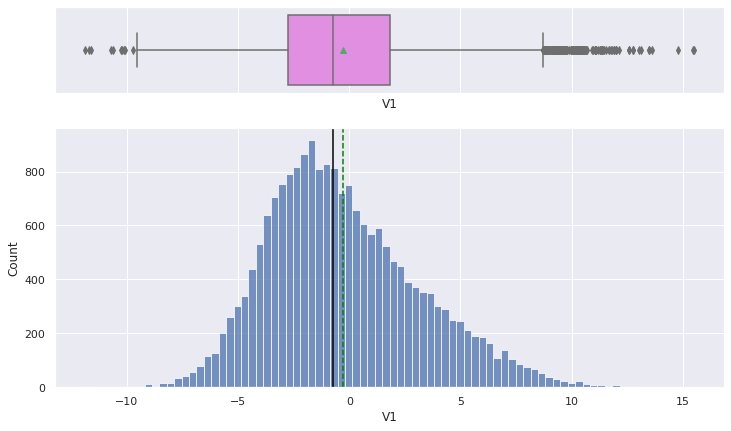

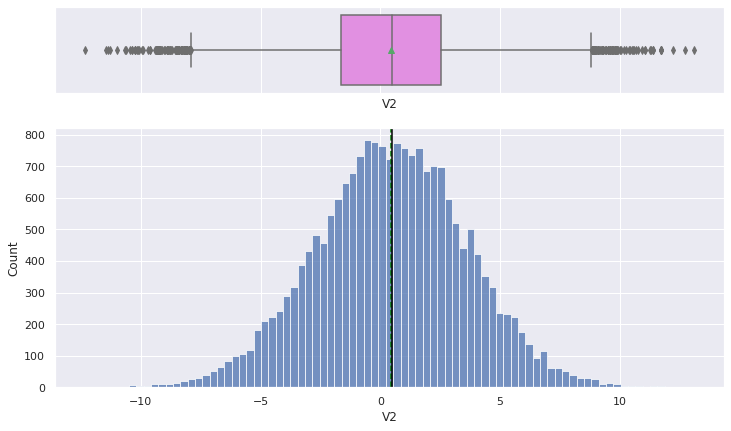

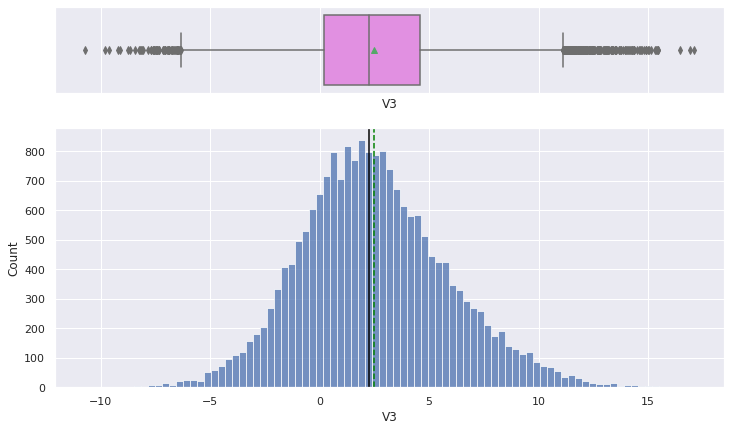

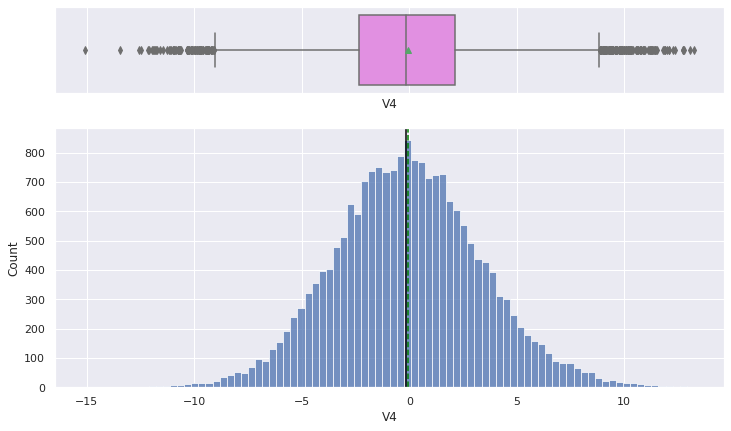

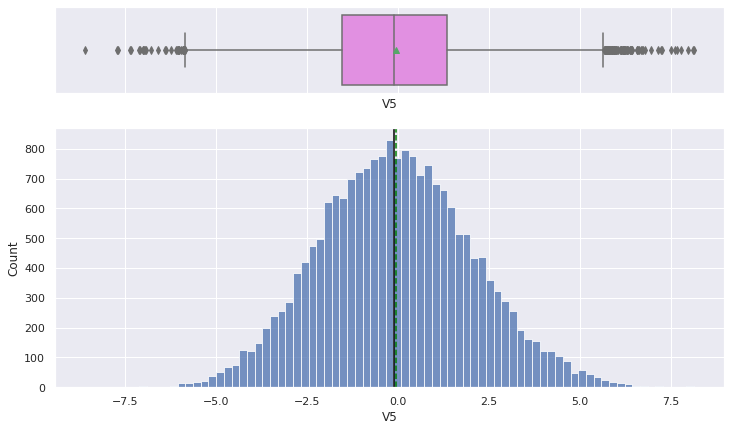

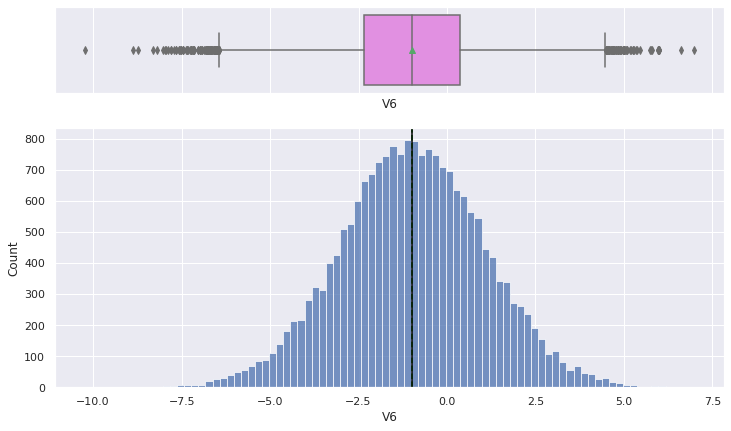

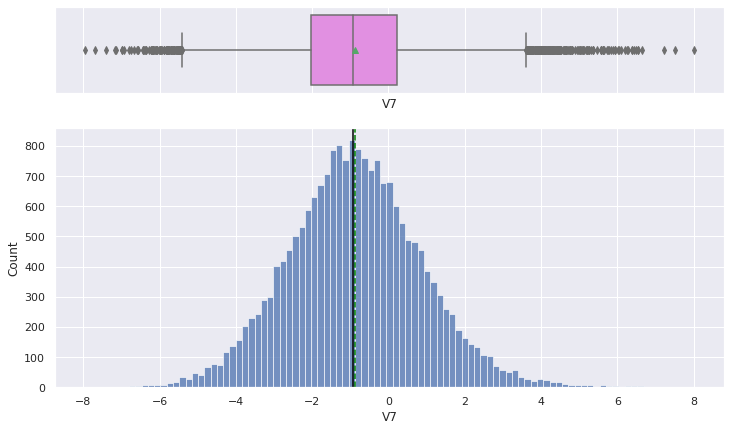

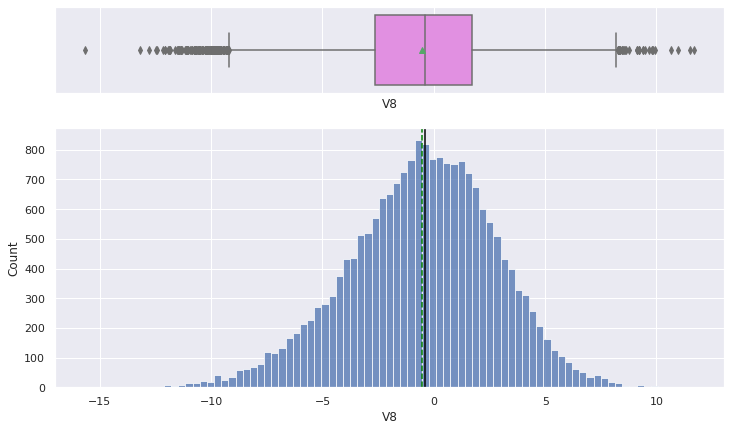

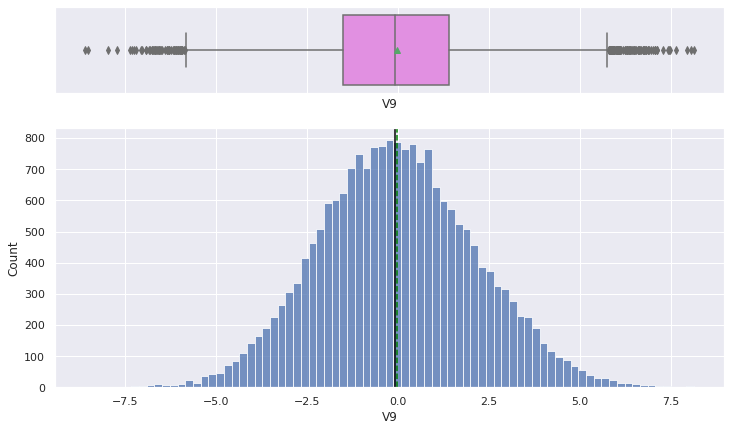

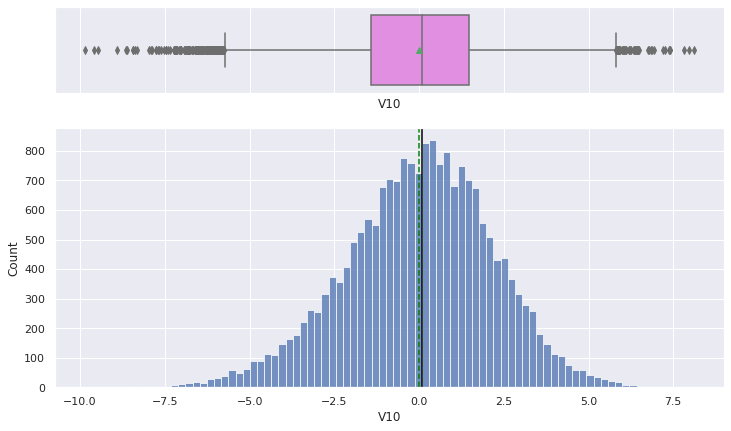

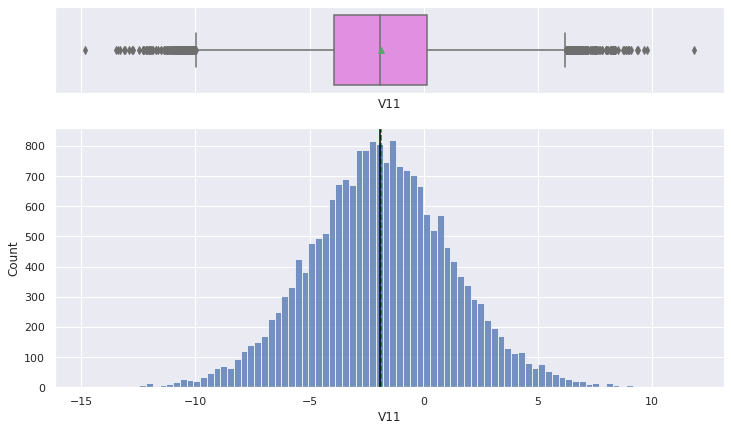

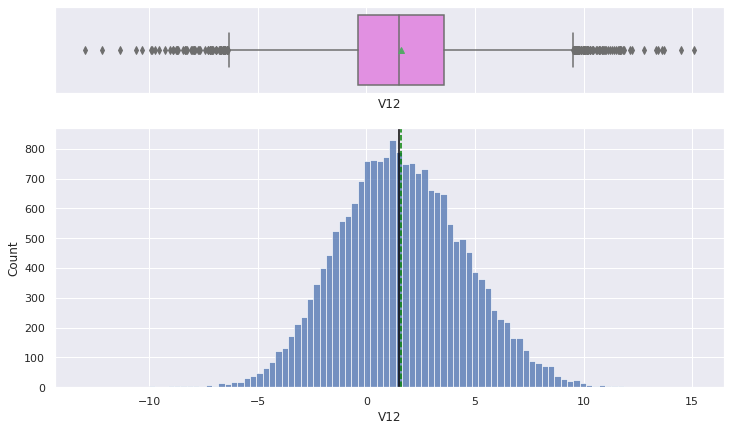

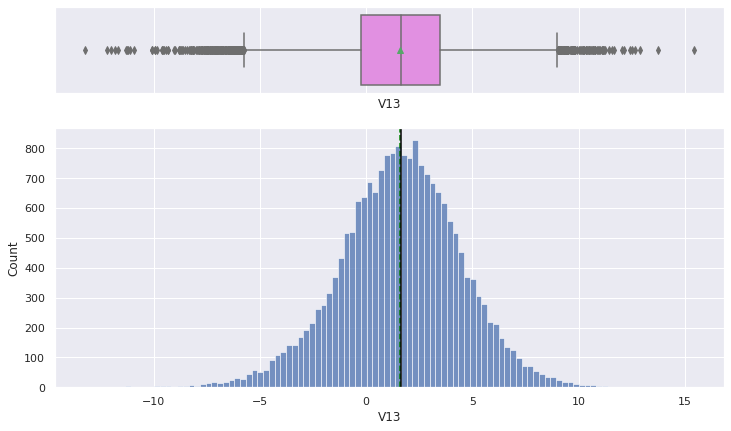

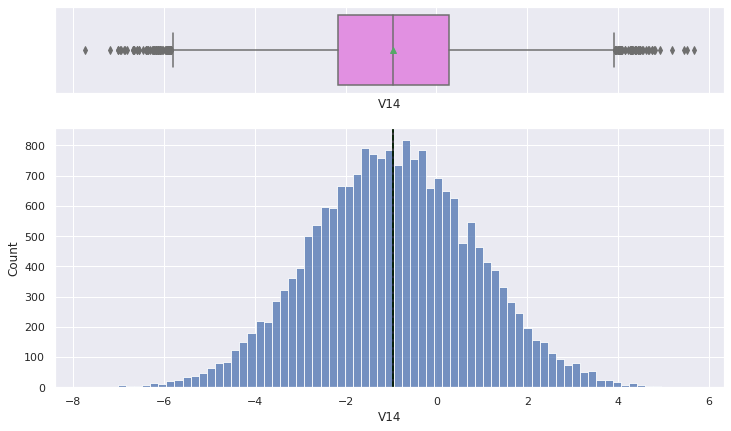

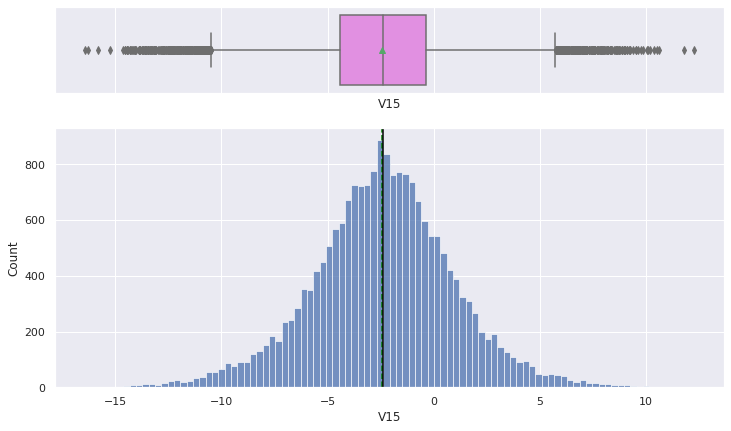

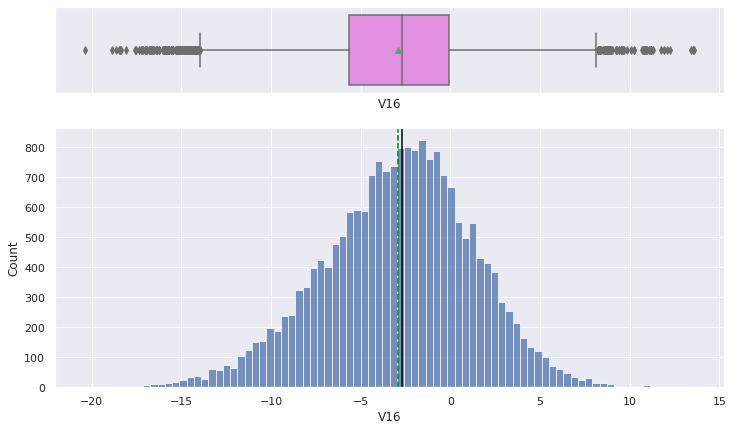

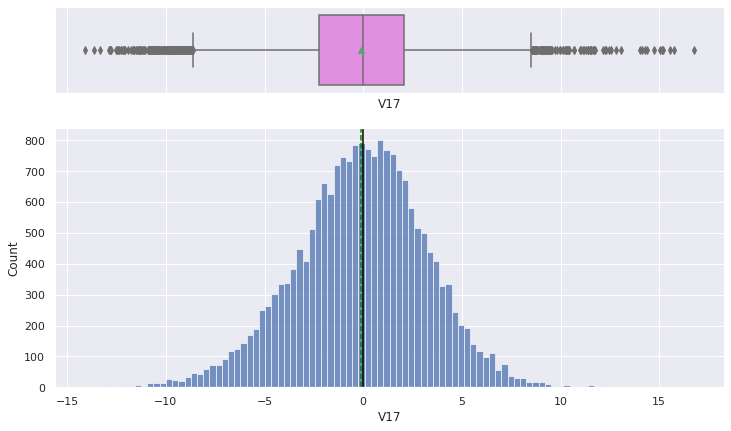

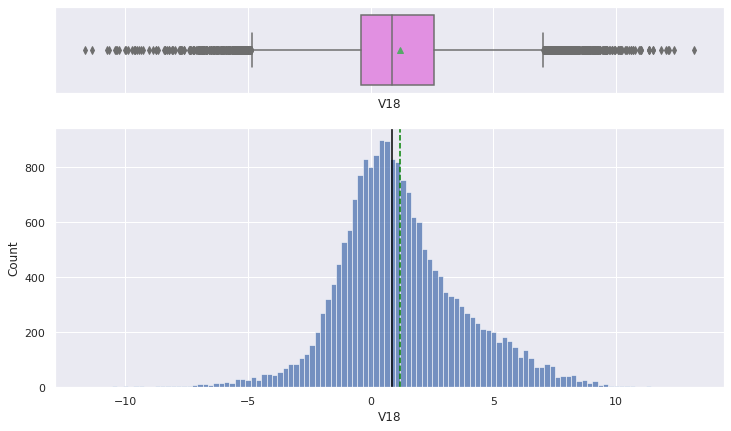

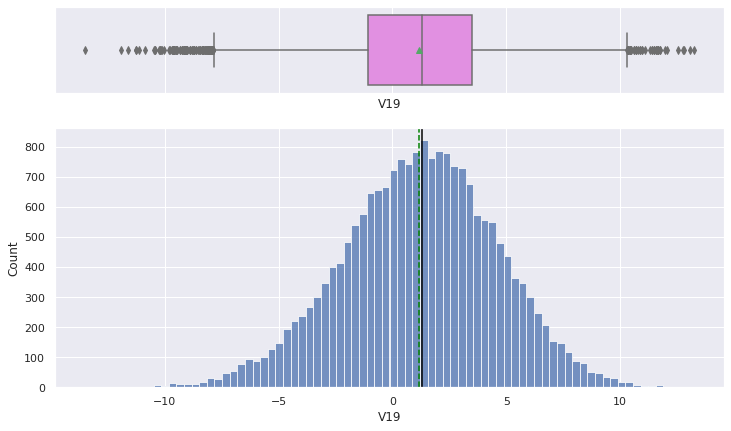

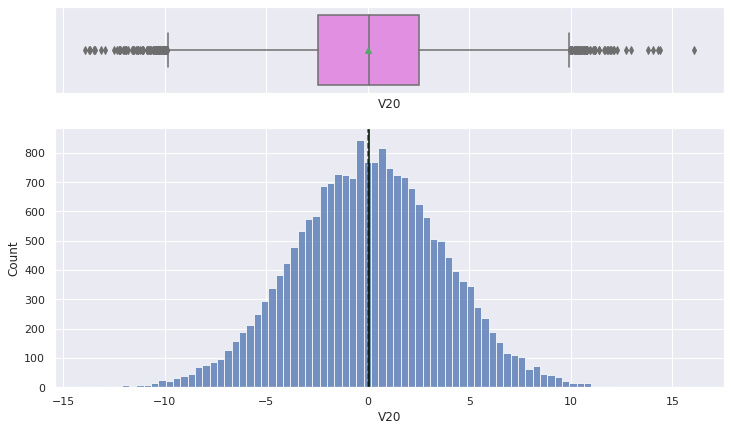

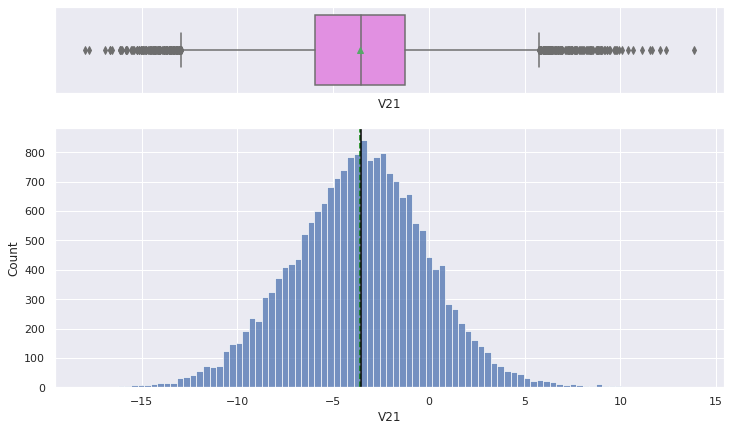

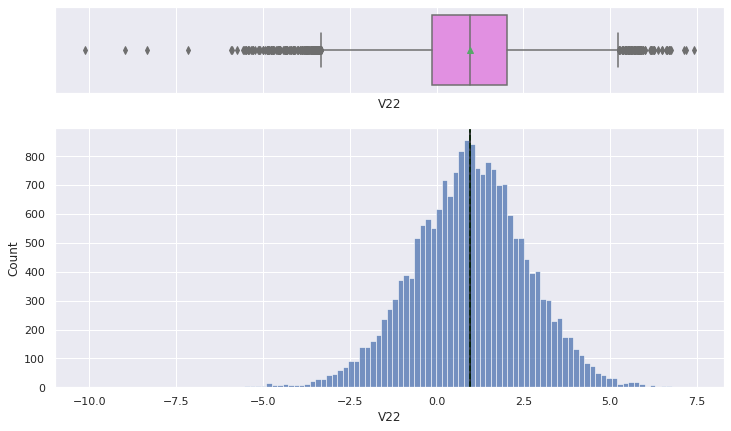

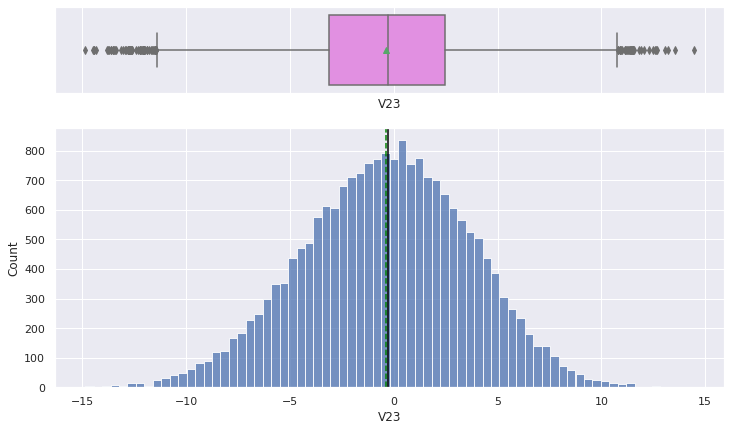

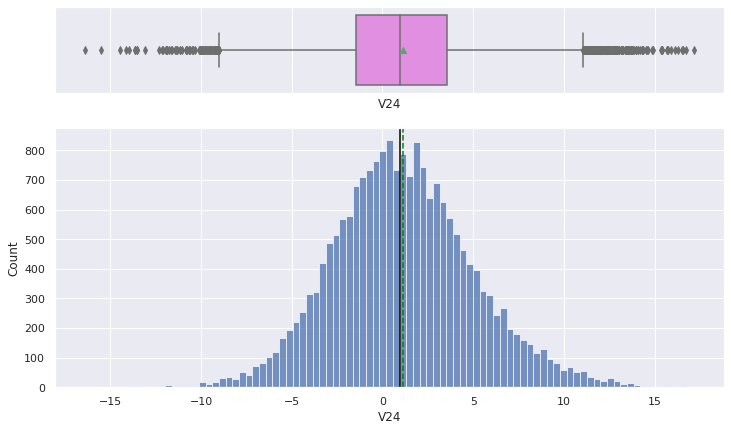

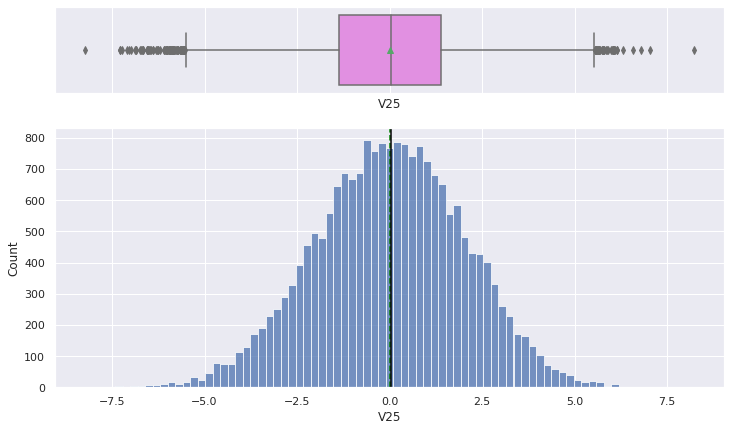

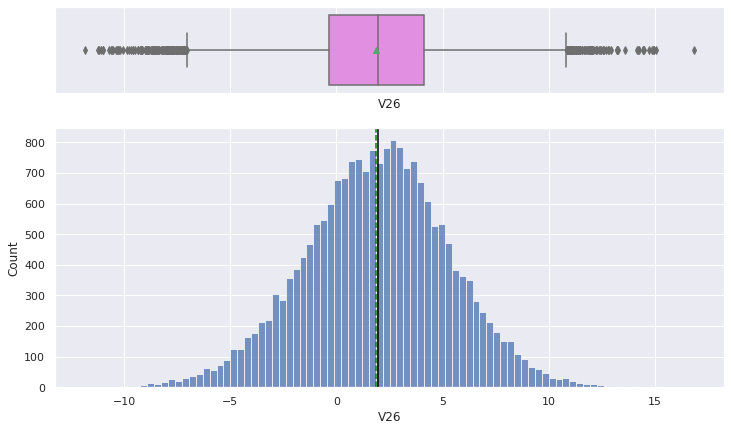

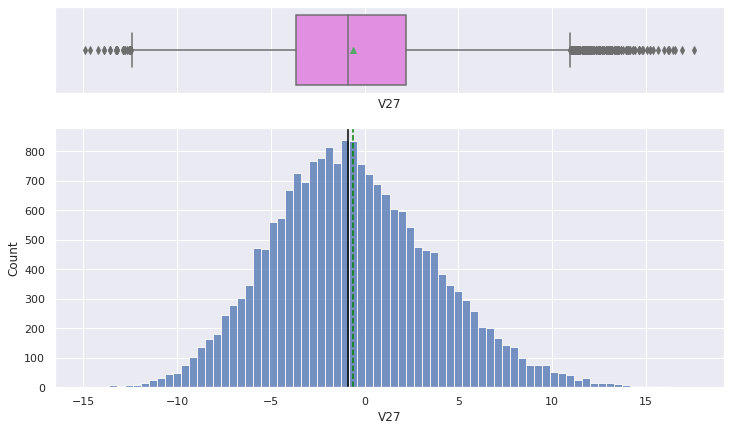

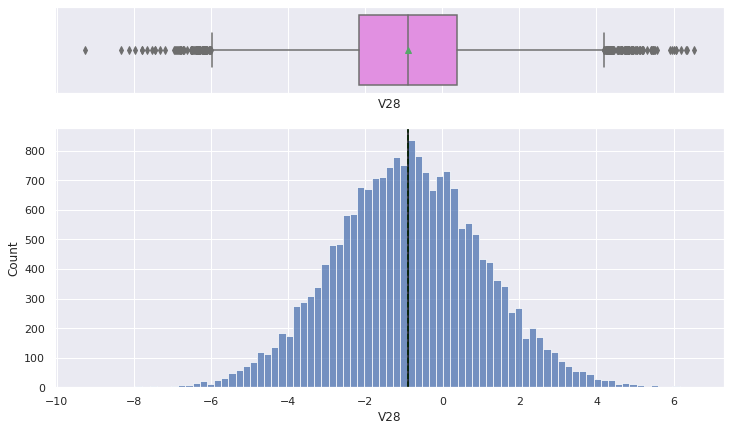

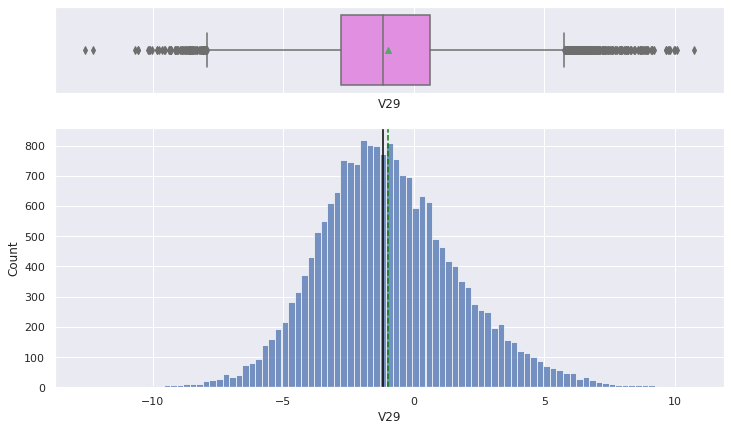

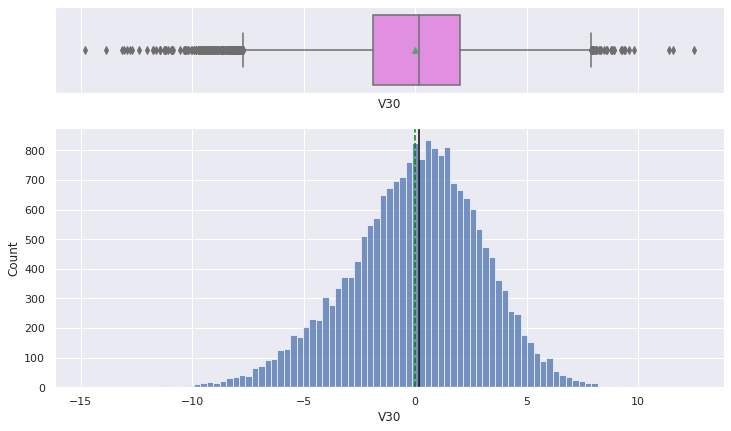

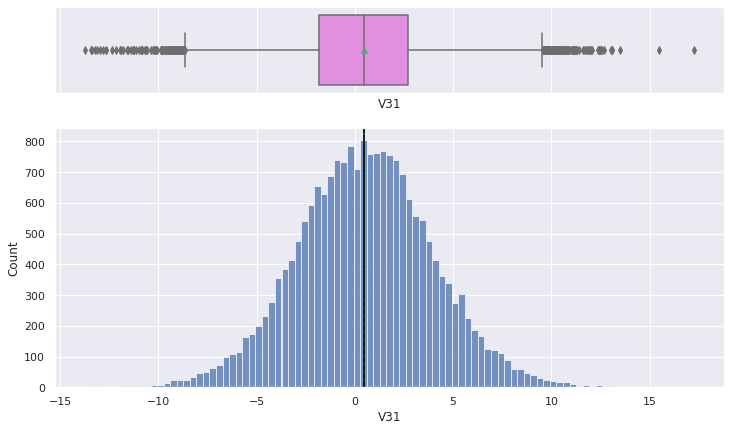

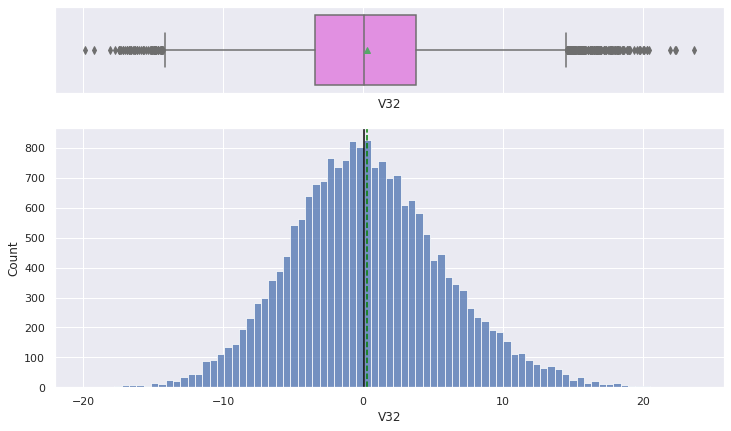

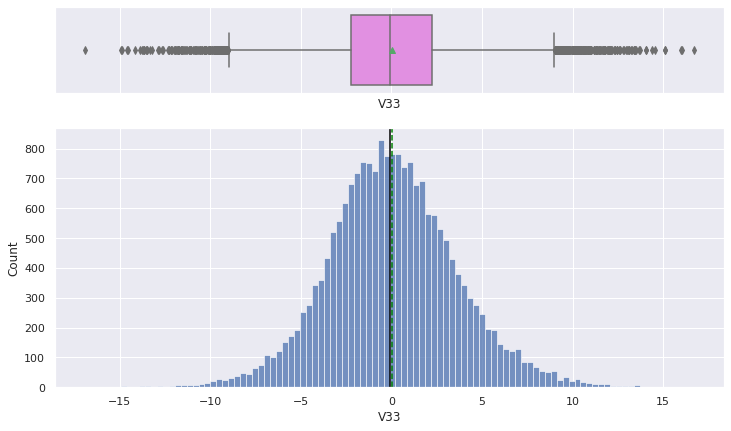

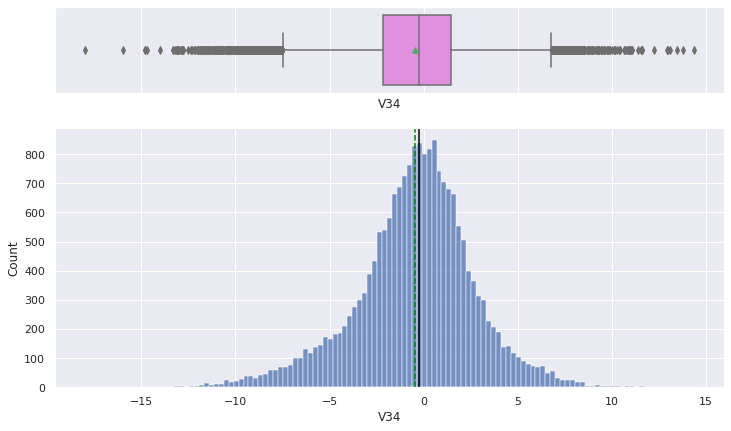

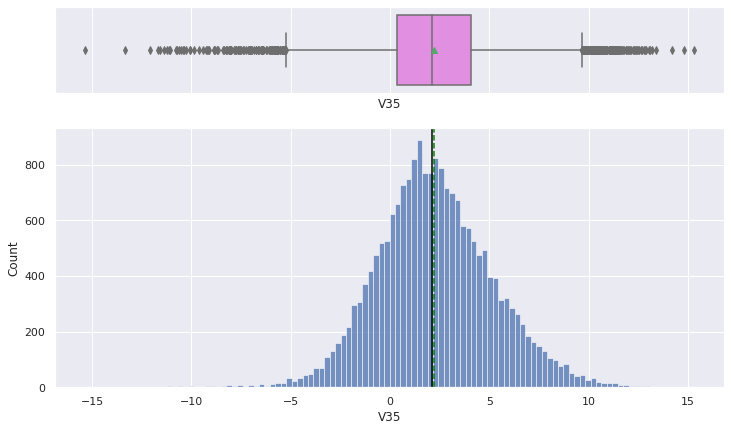

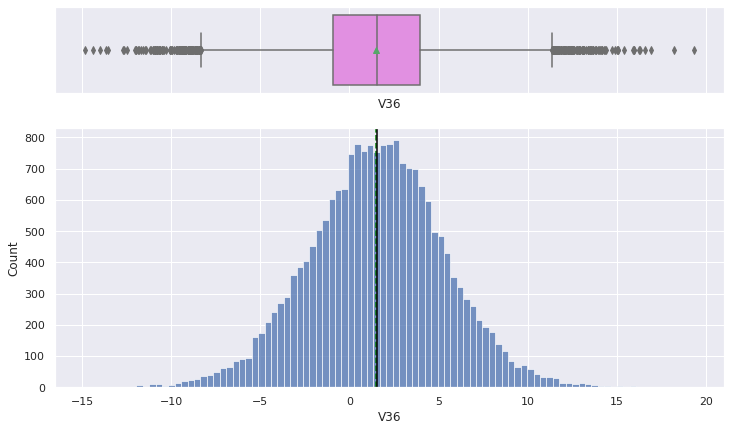

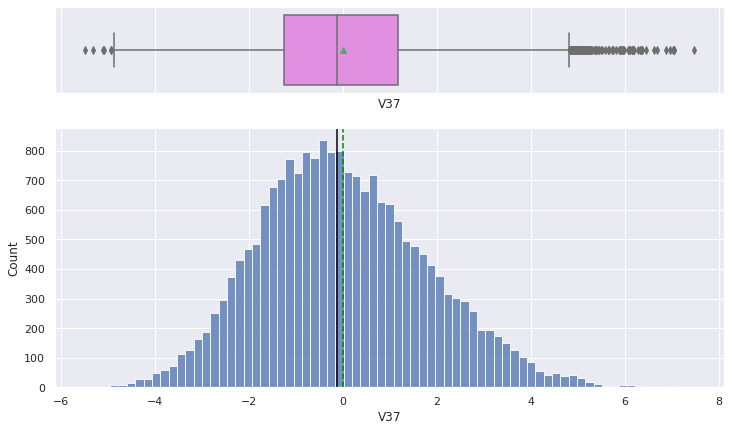

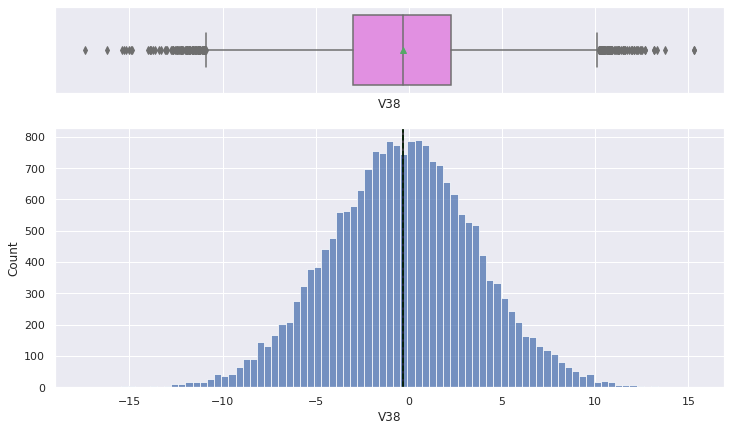

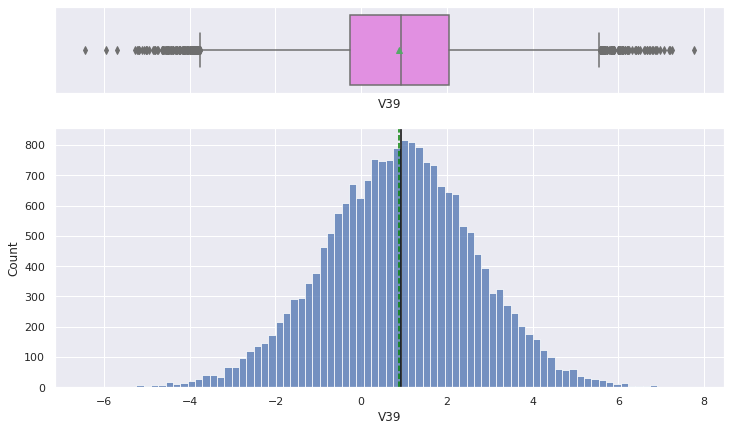

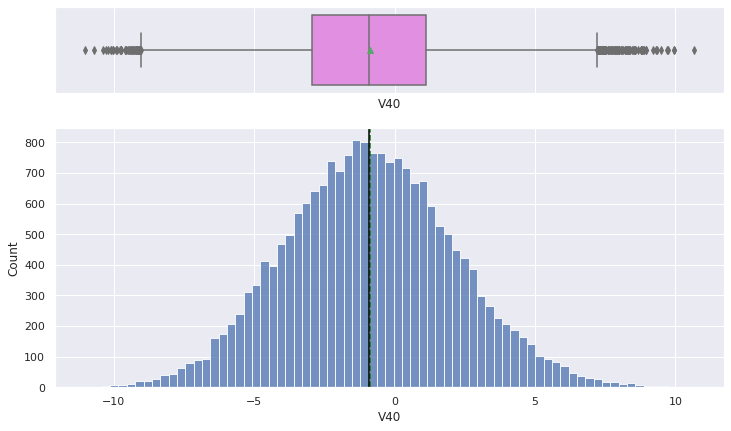

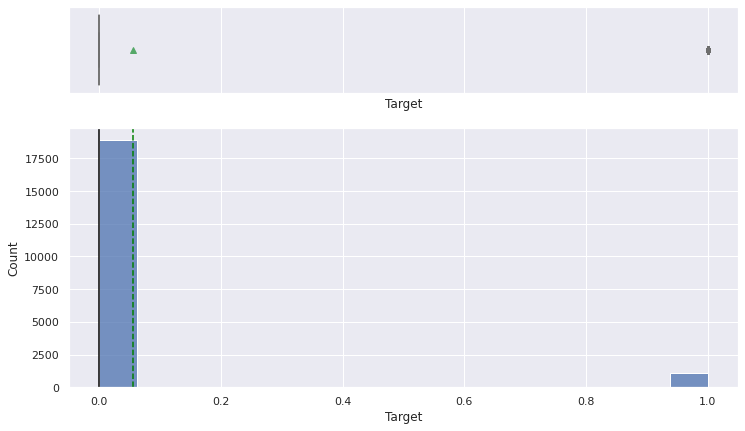

In [ ]:
for feature in df.columns:
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

In [ ]:
# selecting numerical columns
num_col = data.select_dtypes(include=np.number).columns.tolist()

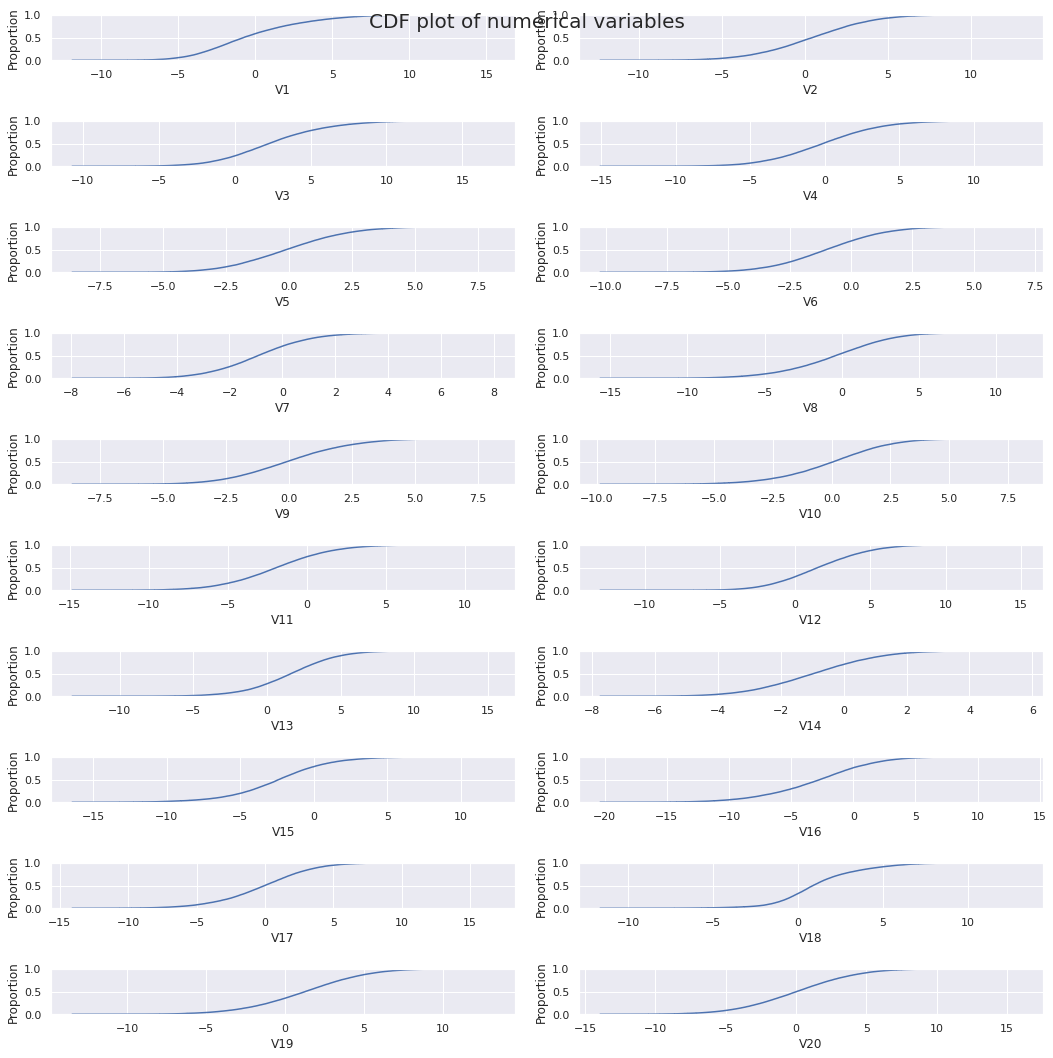

In [ ]:
fig, axes = plt.subplots(10, 2, figsize=(15, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(10):
    sns.ecdfplot(ax=axes[ii][0], x=data[num_col[counter]])
    counter = counter + 1
    if counter != 10:
        sns.ecdfplot(ax=axes[ii][1], x=data[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

- All the variables are normally distributed
- This distribution might not be true for original data but since the provided data is ciphered, this kind of trend in distribution is possible - maybe the original data was transformed to normally distributed data.
- The outliers visible through boxplots are not incorrect readings, the values might be like this only.

In [ ]:
# Frequency tables for target feature in Training 
for column in data.select_dtypes(include=['int64']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))


col_0,% observations
Target,
0,0.945
1,0.056


In [ ]:
# Frequency tables for target feature in Test 
for column in data_test.select_dtypes(include=['int64']).columns:
    display(pd.crosstab(index=data_test[column], columns='% observations', normalize='columns'))


col_0,% observations
Target,
0,0.944
1,0.056


- The distribution of 0s and 1s is the same in both Train and Test sets.
- 94.5% of the observations are negative and only 5.5% of the observations are a positive representing failure.

## Data Pre-processing

In [ ]:
# Dividing data into X and y
X = df.drop(["Target"], axis=1)
y = df["Target"]

X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

In [ ]:
# Splitting data into training and validation set:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)




## Missing value imputation
- There were few missing values in V1 and V2, we will impute them using the median.
- And to avoid data leakage we will impute missing values after splitting train data into train and validation sets.




In [ ]:
imputer = SimpleImputer(strategy="median")


In [ ]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

- There are no missing values

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Sample Decision Tree model building with original data 

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.6982829521679532
Logistic regression: 0.4927566553639709
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.7403217661063415

Validation Performance:

dtree: 0.7050359712230215
Logistic regression: 0.48201438848920863
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.762589928057554


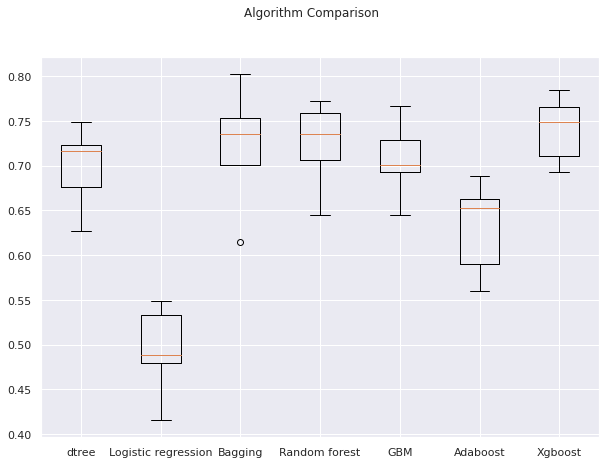

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with Oversampled data


In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores =recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Logistic regression: 0.883963699328486
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.922148207398388
dtree: 0.9720494245534969

Validation Performance:

Logistic regression: 0.8489208633093526
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
Xgboost: 0.8741007194244604
dtree: 0.7769784172661871


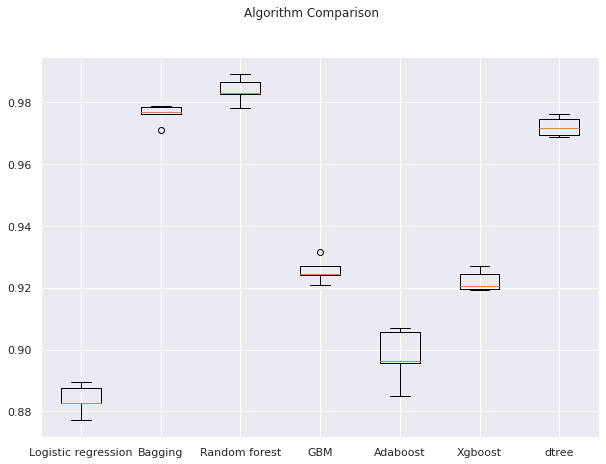

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Logistic regression: 0.8726138085275232
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
GBM: 0.8990621167303946
Adaboost: 0.8666113556020489
Xgboost: 0.9002669360075031
dtree: 0.8617776495202367

Validation Performance:

Logistic regression: 0.8525179856115108
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
Xgboost: 0.8884892086330936
dtree: 0.841726618705036


## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

## Tuning XGBoost using original data

In [ ]:
%%time 

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':np.arange(150,200,250),'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.8642594329413461:
CPU times: user 9.1 s, sys: 398 ms, total: 9.49 s
Wall time: 8min 3s


In [ ]:
xgb1 = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=150,
    learning_rate=0.1,
    gamma=3,
)

xgb1.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', gamma=3, n_estimators=150, random_state=1,
              scale_pos_weight=10, subsample=0.9)

In [ ]:
xgb1_train_perf = model_performance_classification_sklearn(xgb1, X_train, y_train)
xgb1_train_perf

,Accuracy,Recall,Precision,F1
0,0.990,0.941,0.890,0.915


In [ ]:
xgb1_val_perf = model_performance_classification_sklearn(xgb1, X_val, y_val)
xgb1_val_perf

,Accuracy,Recall,Precision,F1
0,0.982,0.863,0.828,0.845


### Sample tuning method for Random Forest tree with oversampled data

In [ ]:
%%time 

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9818606498020482:
CPU times: user 34.5 s, sys: 1.02 s, total: 35.5 s
Wall time: 30min 27s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(
    max_features="sqrt",
    random_state=1,
    max_samples=0.6,
    n_estimators=200,
    min_samples_leaf=1,
)

tuned_rf2.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=200,
                       random_state=1)

In [ ]:
rf2_train_perf = model_performance_classification_sklearn(
    tuned_rf2, X_train_over, y_train_over
)
rf2_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,0.999,1.000,1.000


In [ ]:
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)
rf2_val_perf

,Accuracy,Recall,Precision,F1
0,0.988,0.863,0.920,0.891


### Sample tuning method for GBM with undersampled data

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9026116441815164:


In [ ]:
# Creating new pipeline with best parameters
tuned_gbm2 = GradientBoostingClassifier(
    max_features=0.7,
    random_state=1,
    subsample=0.5,
    n_estimators=100,
    learning_rate=0.2,
)

tuned_gbm2.fit(X_train_un, y_train_un)

In [ ]:
gbm1_train_perf = model_performance_classification_sklearn(tuned_gbm2,X_train_un, y_train_un)
gbm1_train_perf 



,Accuracy,Recall,Precision,F1
0,0.933,0.975,0.451,0.616


In [ ]:
gbm1_val_perf = model_performance_classification_sklearn(tuned_gbm2, X_val, y_val)
gbm1_val_perf 

,Accuracy,Recall,Precision,F1
0,0.919,0.871,0.395,0.543


## Model performance comparison and choosing the final model

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        xgb1_train_perf.T,
        rf2_train_perf.T,
        #bag2_train_perf.T,
        gbm1_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost tuned with original data",
    "XGBoost tuned with oversampled data",
  #  "Bagging classifier tuned with oversampled data",
    "Random forest tuned with oversampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,XGBoost tuned with original data,XGBoost tuned with oversampled data,Random forest tuned with oversampled data
Accuracy,0.990,1.000,0.933
Recall,0.941,0.999,0.975
Precision,0.890,1.000,0.451
F1,0.915,1.000,0.616


In [ ]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        xgb1_val_perf.T,
        gbm1_val_perf.T,
        rf2_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "XGBoost tuned with original data",
    "XGBoost tuned with oversampled data",
 #   "Bagging classifier tuned with oversampled data",
    "Random forest tuned with oversampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,XGBoost tuned with original data,XGBoost tuned with oversampled data,Random forest tuned with oversampled data
Accuracy,0.982,0.919,0.988
Recall,0.863,0.871,0.863
Precision,0.828,0.395,0.920
F1,0.845,0.543,0.891


- Xgboost and Random forest models tuned with oversampled data are performing best.

### Test set final performance

In [ ]:
# Let's check the performance on test set
rf2_test = model_performance_classification_sklearn(tuned_rf2, X_test, y_test)
rf2_test

,Accuracy,Recall,Precision,F1
0,0.987,0.840,0.926,0.881


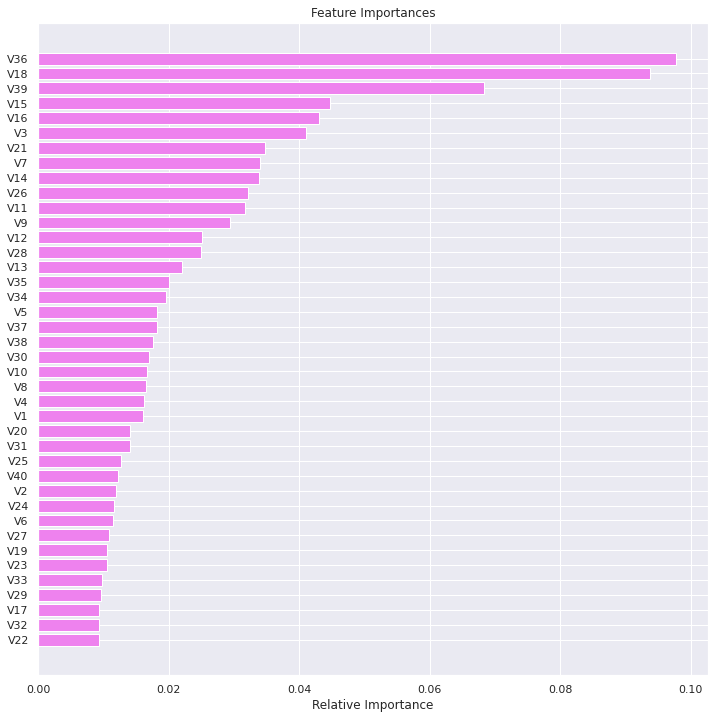

In [ ]:
feature_names = X_train.columns
importances = tuned_rf2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

-V36,V18 and V39 are the important features

## Pipelines to build the final model


In [ ]:
Model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "Random forest",
            RandomForestClassifier(
                max_features="sqrt",
                random_state=1,
                max_samples=0.5000000000000001,
                n_estimators=250,
                min_samples_leaf=1,
            ),
        ),
    ]
)

In [ ]:
# Separating target variable and other variables
X1 = data.drop(columns="Target")
Y1 = data["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

X_test1 = df_test.drop(["Target"], axis=1)
y_test1 = df_test["Target"]

In [ ]:
# We can't oversample data without doing missing value treatment, so let's first treat missing values in train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# We don't need to impute missing values in test set as it will be done inside pipeline

In [ ]:
# We can't oversample data without doing missing value treatment, so let's first treat missing values in train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# We don't need to impute missing values in test set as it will be done inside pipeline

In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [ ]:
Model.fit(X_over1, y_over1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('Random forest',
                 RandomForestClassifier(max_features='sqrt',
                                        max_samples=0.5000000000000001,
                                        n_estimators=250, random_state=1))])

# Business Insights and Conclusions

- The Random Forest tuned using oversampled data has the best performance.
- This model can be further used to detect if a wind turbine will fail or not and this will help reduce the cost.
- V18, V36 and V39 are the most important features. They can be deciphered to determine and analyze the actual variables to understand their impact on the predictive task at hand.

***